In [2]:
from Gao_Algorithm import * 
from Paisley_Algorithm import *
import matplotlib.pyplot as plt
from datafold.pcfold import PCManifold
from sklearn.model_selection import train_test_split
import GPy
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        return (x_train, y_train)

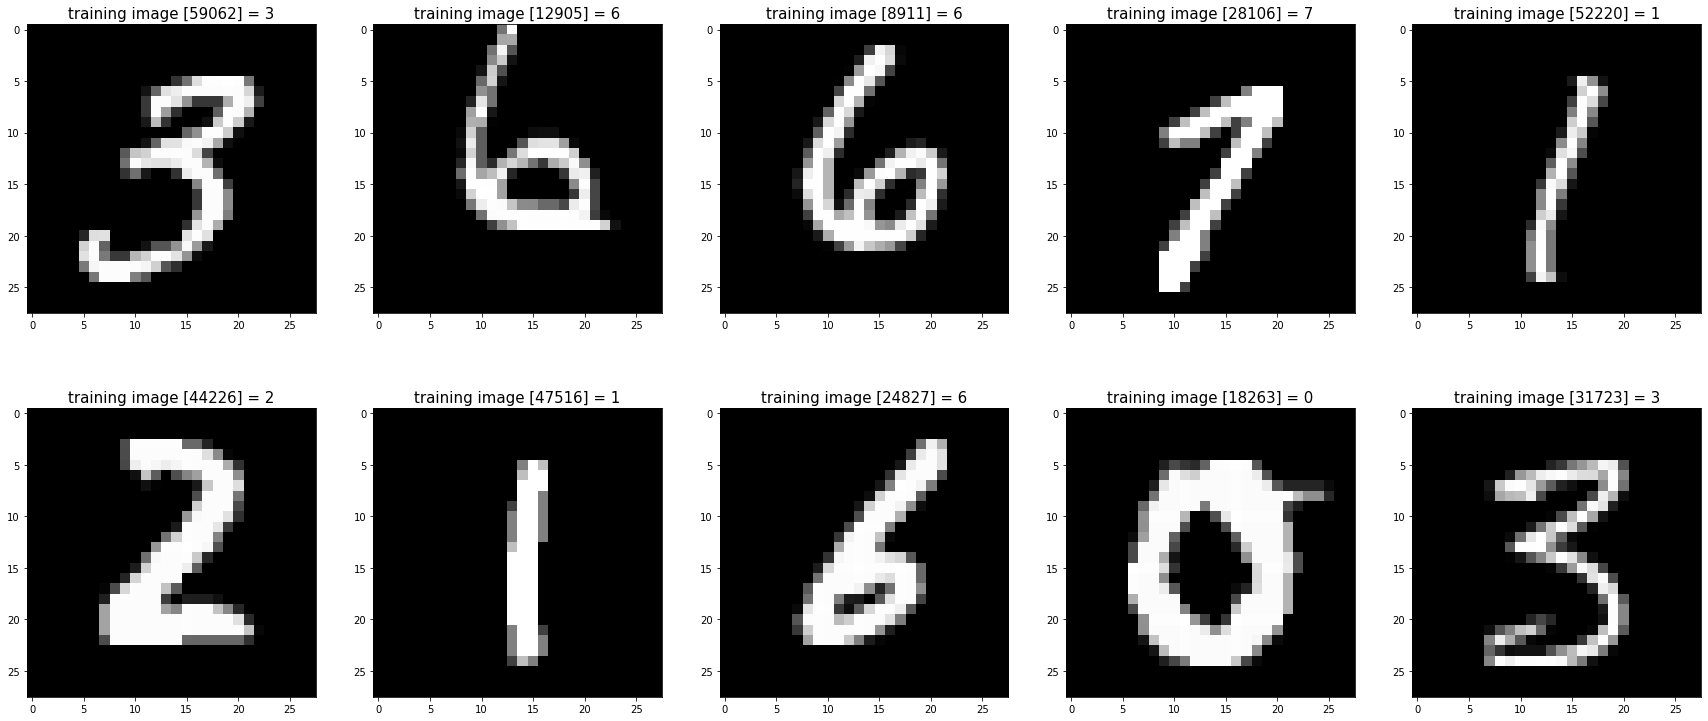

In [4]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = "C:/Users/anany/Desktop/master_thesis-master/"
#input_path = "C:/Users/Z00446CY/Desktop/master_thesis-master/"
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images.idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels.idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath)
(x_train, y_train) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

show_images(images_2_show, titles_2_show)

In [5]:
x_train = np.array(x_train) 
x_train = x_train.reshape(x_train.shape[0], -1)
x_train = x_train / 255.0

In [6]:
image = x_train

In [7]:
y_train = np.array(y_train)
y = y_train

Classes:  [0 1 2 3 4 5 6 7 8 9]
Number of points per class: [5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


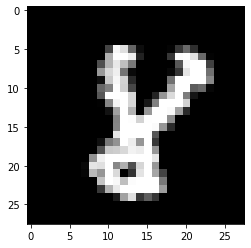

8


In [8]:
n_classes = 10

print("Classes: ", np.unique(y))
print("Number of points per class:", [np.sum(y==k) for k in np.unique(y)])

random_state = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(image, y, test_size=test_size, random_state=random_state)
plt.gray() 
plt.imshow(X_train[20, :].reshape(28, 28)) 
plt.show()
print(y_train[20])
# note that y_test and X_test is never used below.

In [30]:
#####DIVIDING DATASETS INTO BATCHES ##### 

num_lmk_per_batch = 30 # how many landmarks to find per batch
batch_size = 100       # points per batch
n_batches = 2 # number of batches chosen per class

total_landmarks = np.array([])
idx_all = np.arange(X_train.shape[0])

# define a random number generator and use it to draw samples for batching
_rng = np.random.default_rng(random_state)
x = []
x_labels = []
for current_class in np.unique(y_train):
    
    # setup the dataset for the current class
    idx_class = (y_train == current_class)
    X_train_class = X_train[idx_class, :]
    y_train_class = y_train[idx_class]
    total_landmarks_class = np.array([])
    
    print(f"Number of points in class {current_class}: {X_train_class.shape[0]}")
    
    for _ in range(n_batches):
    
        # draw new batch at random
        batch_indices = _rng.choice(X_train_class.shape[0], size=(batch_size,))
        cat_data = X_train_class[batch_indices,:]
        x.append(cat_data)
        x_labels.append(y_train_class[batch_indices])
        # append the previous landmark data points to the array so that we can use them for the next landmarking call
        if len(total_landmarks_class) > 0:
            cat_data = np.row_stack([X_train_class[total_landmarks_class,:], cat_data])
        print(f"cat_data shape: {cat_data.shape[0]}")
        (GPLmkIdx, ptuq) = GetGPLmk_Euclidean(cat_data, num_lmk_per_batch, batch_size, BNN = 10, len(total_landmarks_class))
        # clean up the new indices by removing the ones we know
        GPLmkIdx = GPLmkIdx[len(total_landmarks_class):] - len(total_landmarks_class)
        GPLmkIdx = GPLmkIdx[GPLmkIdx >= 0]
        # add the new indices to the old ones
        unique_new_landmarks = np.unique(batch_indices[GPLmkIdx])
        total_landmarks_class = np.concatenate([total_landmarks_class, unique_new_landmarks]).astype(np.int)
    
    print(f"Found {len(total_landmarks_class)} landmarks for class {current_class}.")
    
    total_landmarks = np.concatenate([total_landmarks, idx_all[idx_class][total_landmarks_class]]).astype(np.int)
    
print(f"Total number of landmarks: {len(total_landmarks)}")
tot_landmarks = np.array(total_landmarks)
tot_landmarks = tot_landmarks.reshape(-1, )
x = np.array(x)
x = x.reshape(10 * n_batches * batch_size, -1)
x_labels = np.array(x_labels)
x_labels = x_labels.reshape(-1, )

Number of points in class 0: 4748
cat_data shape: 100
cat_data shape: 116
Found 21 landmarks for class 0.
Number of points in class 1: 5420
cat_data shape: 100
cat_data shape: 116
Found 21 landmarks for class 1.
Number of points in class 2: 4784
cat_data shape: 100
cat_data shape: 115
Found 22 landmarks for class 2.
Number of points in class 3: 4912
cat_data shape: 100
cat_data shape: 116
Found 24 landmarks for class 3.
Number of points in class 4: 4666
cat_data shape: 100
cat_data shape: 116
Found 22 landmarks for class 4.
Number of points in class 5: 4317
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 5.
Number of points in class 6: 4741
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 6.
Number of points in class 7: 4966
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 7.
Number of points in class 8: 4691
cat_data shape: 100
cat_data shape: 115
Found 21 landmarks for class 8.
Number of points in class 9: 4755
cat_data sha

In [10]:
#land = tot_landmarks[:30]
#land = land.reshape(land.shape[0], 28, 28)
tempGPLmkIdx = tot_landmarks[:30]
land = X_train[tempGPLmkIdx]
land = land.reshape(land.shape[0], 28, 28)
land.shape

(30, 28, 28)

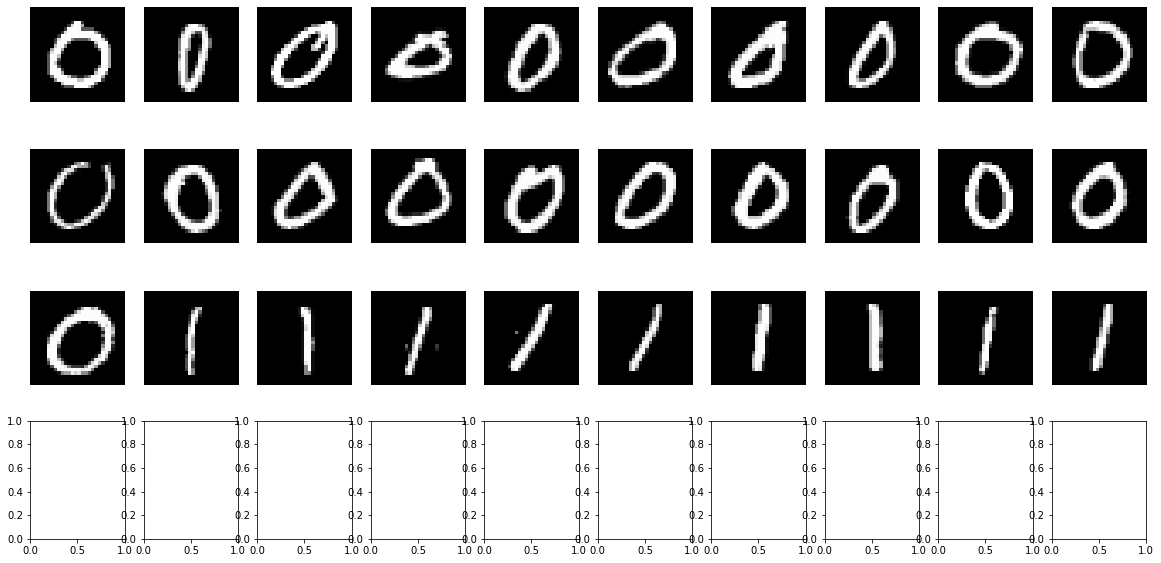

In [39]:
f, axarr = plt.subplots(int(np.ceil(land.shape[0] / 10.0)) + 1, 10,figsize=(20,10))
for i in range(land.shape[0]):
    axarr[int(np.floor(i / 10)), (i % 10)].imshow(land[i], cmap='gray')
    axarr[int(np.floor(i / 10)), (i % 10)].axis('off')

In [25]:
x.shape

(2000, 784)

In [35]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(x_labels.reshape(-1, 1))
onehot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [36]:
number_of_classes = 10
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

In [37]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

 C:\Users\anany\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\anany\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:52: RuntimeWarning:overflow encountered in square
 C:\Users\anany\Anaconda3\lib\site-packages\GPy\kern\src\rbf.py:76: RuntimeWarning:invalid value encountered in multiply


In [38]:
def landmark_gp_clustering_accuracy(landmarks, landmark_labels, coords, y):
    if(landmarks.shape[0] < 10):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [33]:
np.random.shuffle(tot_landmarks)

In [39]:
accuracies_gp = [landmark_gp_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0,tot_landmarks.shape[0] , 1)]

Landmarks:  10 Accuracy:  0.18225
Landmarks:  11 Accuracy:  0.19566666666666666
Landmarks:  12 Accuracy:  0.20125
Landmarks:  13 Accuracy:  0.249
Landmarks:  14 Accuracy:  0.2705
Landmarks:  15 Accuracy:  0.25683333333333336
Landmarks:  16 Accuracy:  0.2529166666666667
Landmarks:  17 Accuracy:  0.2648333333333333
Landmarks:  18 Accuracy:  0.26966666666666667
Landmarks:  19 Accuracy:  0.243
Landmarks:  20 Accuracy:  0.26425
Landmarks:  21 Accuracy:  0.2500833333333333
Landmarks:  22 Accuracy:  0.28608333333333336
Landmarks:  23 Accuracy:  0.28341666666666665
Landmarks:  24 Accuracy:  0.3769166666666667
Landmarks:  25 Accuracy:  0.37133333333333335
Landmarks:  26 Accuracy:  0.37816666666666665
Landmarks:  27 Accuracy:  0.38
Landmarks:  28 Accuracy:  0.38133333333333336
Landmarks:  29 Accuracy:  0.3849166666666667
Landmarks:  30 Accuracy:  0.3759166666666667
Landmarks:  31 Accuracy:  0.39691666666666664
Landmarks:  32 Accuracy:  0.3968333333333333
Landmarks:  33 Accuracy:  0.3955833333333

Landmarks:  205 Accuracy:  0.804
Landmarks:  206 Accuracy:  0.8054166666666667
Landmarks:  207 Accuracy:  0.8054166666666667
Landmarks:  208 Accuracy:  0.8056666666666666
Landmarks:  209 Accuracy:  0.8065
Landmarks:  210 Accuracy:  0.8079166666666666
Landmarks:  211 Accuracy:  0.8079166666666666
Landmarks:  212 Accuracy:  0.808
Landmarks:  213 Accuracy:  0.8083333333333333
Landmarks:  214 Accuracy:  0.81025
Landmarks:  215 Accuracy:  0.8103333333333333
Landmarks:  216 Accuracy:  0.8103333333333333
Landmarks:  217 Accuracy:  0.8113333333333334
Landmarks:  218 Accuracy:  0.8109166666666666


In [14]:
accuracies_gp = accuracies_gp[:152]

In [18]:
len(accuracies_knn)

151

In [40]:
def landmark_clustering_accuracy(landmarks, landmarks_labels, coords, y):
    if(landmarks.shape[0] < 10 ):
        return 0
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmarks_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [34]:
accuracies_knn = [landmark_clustering_accuracy(X_train[tot_landmarks[:i], :], y_train[tot_landmarks[:i]], X_test, y_test) for i in range(0, 152, 1)]

Landmarks:  10 Accuracy:  0.2951666666666667
Landmarks:  11 Accuracy:  0.31625
Landmarks:  12 Accuracy:  0.3461666666666667
Landmarks:  13 Accuracy:  0.3478333333333333
Landmarks:  14 Accuracy:  0.37925
Landmarks:  15 Accuracy:  0.3839166666666667
Landmarks:  16 Accuracy:  0.4534166666666667
Landmarks:  17 Accuracy:  0.45375
Landmarks:  18 Accuracy:  0.47483333333333333
Landmarks:  19 Accuracy:  0.48933333333333334
Landmarks:  20 Accuracy:  0.48433333333333334
Landmarks:  21 Accuracy:  0.48833333333333334
Landmarks:  22 Accuracy:  0.4985833333333333
Landmarks:  23 Accuracy:  0.49966666666666665
Landmarks:  24 Accuracy:  0.49725
Landmarks:  25 Accuracy:  0.4965833333333333
Landmarks:  26 Accuracy:  0.4985
Landmarks:  27 Accuracy:  0.4975833333333333
Landmarks:  28 Accuracy:  0.5135833333333333
Landmarks:  29 Accuracy:  0.5121666666666667
Landmarks:  30 Accuracy:  0.5216666666666666
Landmarks:  31 Accuracy:  0.5335833333333333
Landmarks:  32 Accuracy:  0.5365833333333333
Landmarks:  33 A

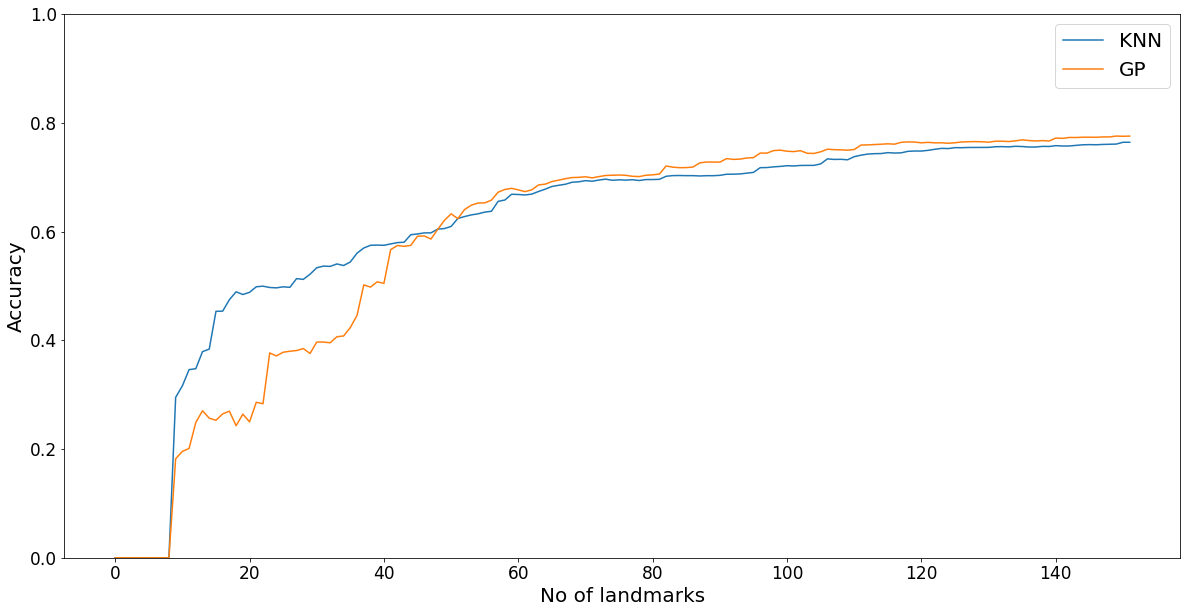

In [20]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, 152, 1), accuracies_knn, label = "KNN")
plt.plot(range(0, 152, 1), accuracies_gp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
plt.legend(fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_gao_mnist.png')

In [10]:
count = np.zeros(10)
tot_landmarks = np.array([])
labels = []
x = []
for j in range(5):
    cat_data = []
    new_labels = []
    for i in range(y_train.shape[0]):
        if (y_train[i] == j and count[y_train[i]] < 100):
            new_labels.append(y_train[i])
            cat_data.append(X_train[i])
            count[y_train[i]] += 1
    new_labels = np.array(new_labels)
    cat_data = np.array(cat_data)
    if j==0:
        mgp = ManifoldGP(n_landmarks=21, landmarks=None)
    else:
        mgp = ManifoldGP(n_landmarks=30, landmarks=tot_landmarks)
    mgp.learn_landmarks(cat_data, batch_size = 100)
    tot_landmarks = mgp.landmarks
    print(mgp.landmarks.shape)
    print(tot_landmarks.shape)
    labels.append(new_labels)
    x.append(cat_data)
tot_landmarks = np.array(tot_landmarks)
labels = np.array(labels)
labels = labels.reshape(-1, 1)
x = np.array(x)
x.shape

bandwidth:  315.42109108370306
Learning landmark 0:
Progress: 1000/1000
Learning landmark 1:
Progress: 50/1000

 <ipython-input-7-288ec1fa290c>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
(21, 784)
(21, 784)
bandwidth:  172.06122730309104
Learning landmark 0:


 <ipython-input-7-288ec1fa290c>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-7-288ec1fa290c>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-7-288ec1fa290c>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

 <ipython-input-7-288ec1fa290c>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
Learning landmark 5:
Progress: 1000/1000
Learning landmark 6:
Progress: 1000/1000
Learning landmark 7:
Progress: 1000/1000
Learning landmark 8:
Progress: 1000/1000
Learning landmark 9:
Progress: 1000/1000
Learning landmark 10:
Progress: 1000/1000
Learning landmark 11:
Progress: 1000/1000
Learning landmark 12:
Progress: 1000/1000
Learning landmark 13:
Progress: 1000/1000
Learning landmark 14:
Progress: 1000/1000
Learning landmark 15:
Progress: 1000/1000
Learning landmark 16:
Progress: 1000/1000
Learning landmark 17:
Progress: 1000/1000
Learning landmark 18:
Progress: 1000/1000
Learning landmark 19:
Progress: 1000/1000
Learning landmark 20:
Progress: 1000/1000
Learning landmark 21:
Progress: 1000/1000
Learning landmark 22:
Progress: 1000/1000
Learning landmark 23:
Progress: 1000/1000
Learning landmark 24:
P

(5, 100, 784)

In [11]:
x = x.reshape(500,784)

In [12]:
land = tot_landmarks[:30]
land = land.reshape(land.shape[0], 28, 28)
land.shape

(30, 28, 28)

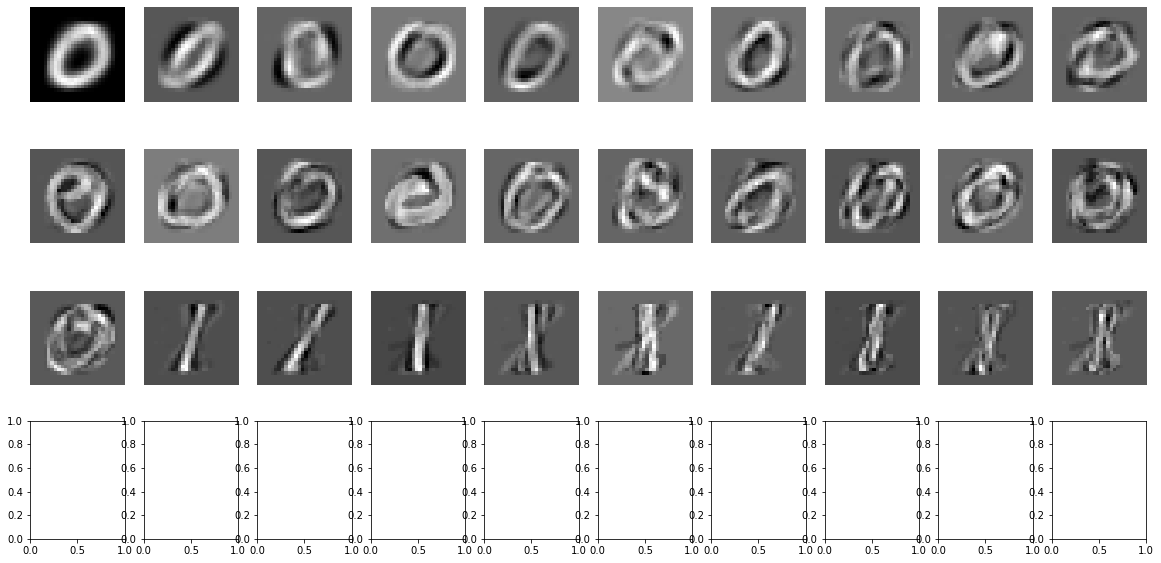

In [13]:
f, axarr = plt.subplots(int(np.ceil(land.shape[0] / 10.0)) + 1, 10,figsize=(20,10))
for i in range(land.shape[0]):
    axarr[int(np.floor(i / 10)), (i % 10)].imshow(land[i], cmap='gray')
    axarr[int(np.floor(i / 10)), (i % 10)].axis('off')

In [82]:
kernel = 9.832586352198769 * RBF(0.6822266430968936)
gpc_true = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_train, y_train)

In [83]:
def landmark_gp_paisley_clustering_accuracy(gpc_true, landmarks, coords, y):
    if(landmarks.shape[0] < 5):
        return 0
    kernel = 9.832586352198769 * RBF(0.6822266430968936)
    landmark_labels = gpc_true.predict(landmarks)
    labels
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0, max_iter_predict = 1000).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [87]:
accuracies_pgp = [landmark_gp_paisley_clustering_accuracy(gpc_true, tot_landmarks[:i, :], X_test, y_test) for i in range(0, 150, 1)]

Landmarks:  5 Accuracy:  0.384
Landmarks:  6 Accuracy:  0.404
Landmarks:  7 Accuracy:  0.412
Landmarks:  8 Accuracy:  0.412
Landmarks:  9 Accuracy:  0.476
Landmarks:  10 Accuracy:  0.468
Landmarks:  11 Accuracy:  0.528
Landmarks:  12 Accuracy:  0.604
Landmarks:  13 Accuracy:  0.604
Landmarks:  14 Accuracy:  0.636
Landmarks:  15 Accuracy:  0.656
Landmarks:  16 Accuracy:  0.656
Landmarks:  17 Accuracy:  0.692
Landmarks:  18 Accuracy:  0.692
Landmarks:  19 Accuracy:  0.692
Landmarks:  20 Accuracy:  0.692
Landmarks:  21 Accuracy:  0.752
Landmarks:  22 Accuracy:  0.74
Landmarks:  23 Accuracy:  0.74
Landmarks:  24 Accuracy:  0.744
Landmarks:  25 Accuracy:  0.72
Landmarks:  26 Accuracy:  0.72
Landmarks:  27 Accuracy:  0.72
Landmarks:  28 Accuracy:  0.72
Landmarks:  29 Accuracy:  0.736
Landmarks:  30 Accuracy:  0.736
Landmarks:  31 Accuracy:  0.74
Landmarks:  32 Accuracy:  0.732
Landmarks:  33 Accuracy:  0.72
Landmarks:  34 Accuracy:  0.712
Landmarks:  35 Accuracy:  0.724
Landmarks:  36 Accura

In [85]:
def landmark_paisley_clustering_accuracy(landmarks, coords, y):
    if(landmarks.shape[0] < 5 ):
        return 0
    knn_true = KNeighborsClassifier(n_neighbors=1).fit(coords, y)
    landmark_labels = knn_true.predict(landmarks)
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmark_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [88]:
accuracies_pknn = [landmark_paisley_clustering_accuracy(tot_landmarks[:i, :], X_test, y_test) for i in range(0, 150, 1)]

Landmarks:  5 Accuracy:  0.356
Landmarks:  6 Accuracy:  0.356
Landmarks:  7 Accuracy:  0.356
Landmarks:  8 Accuracy:  0.38
Landmarks:  9 Accuracy:  0.452
Landmarks:  10 Accuracy:  0.452
Landmarks:  11 Accuracy:  0.5
Landmarks:  12 Accuracy:  0.544
Landmarks:  13 Accuracy:  0.544
Landmarks:  14 Accuracy:  0.596
Landmarks:  15 Accuracy:  0.632
Landmarks:  16 Accuracy:  0.632
Landmarks:  17 Accuracy:  0.66
Landmarks:  18 Accuracy:  0.66
Landmarks:  19 Accuracy:  0.676
Landmarks:  20 Accuracy:  0.676
Landmarks:  21 Accuracy:  0.76
Landmarks:  22 Accuracy:  0.724
Landmarks:  23 Accuracy:  0.724
Landmarks:  24 Accuracy:  0.74
Landmarks:  25 Accuracy:  0.704
Landmarks:  26 Accuracy:  0.704
Landmarks:  27 Accuracy:  0.704
Landmarks:  28 Accuracy:  0.704
Landmarks:  29 Accuracy:  0.704
Landmarks:  30 Accuracy:  0.704
Landmarks:  31 Accuracy:  0.704
Landmarks:  32 Accuracy:  0.704
Landmarks:  33 Accuracy:  0.704
Landmarks:  34 Accuracy:  0.704
Landmarks:  35 Accuracy:  0.704
Landmarks:  36 Accur

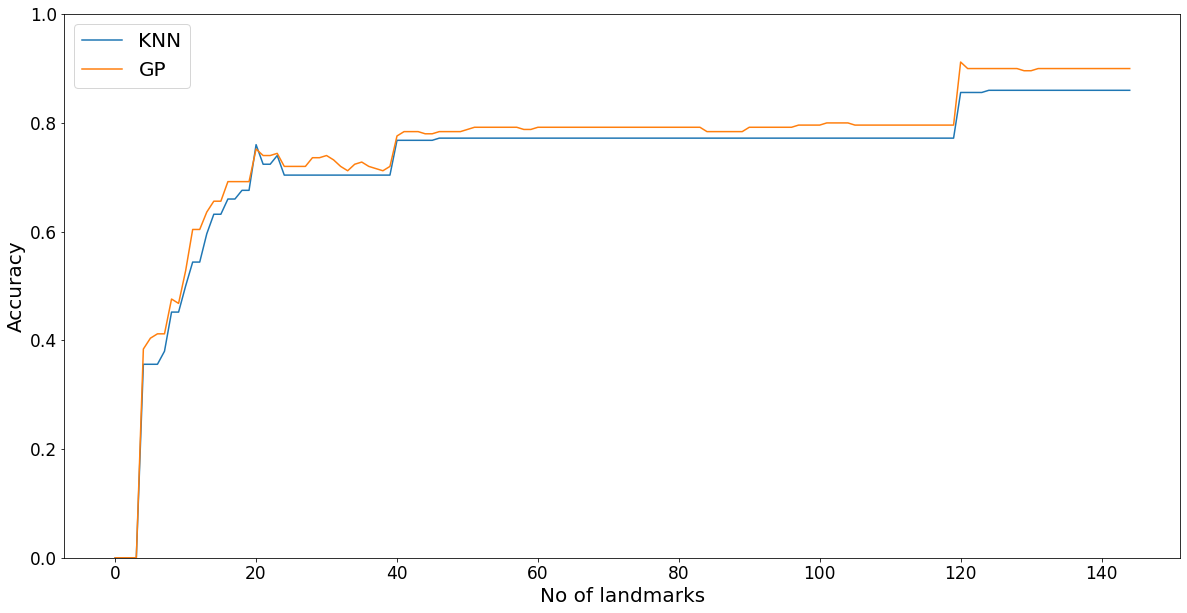

In [12]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, 145, 1), accuracies_pknn, label = "KNN")
plt.plot(range(0, 145, 1), accuracies_pgp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
#plt.title('Gao algorithm accuracies vs landmarks using KNN and GP' ,fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.legend(fontsize=20)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_paisley_mnist.png')